In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
mpl.rcParams['savefig.dpi'] = 300

In [2]:
pre_train = 10
epoch = 3000
path = 'results/last/'
tasks = ['Push', 'Hit', 'Stack']
#9d5783
model_colors = {'singletask': '#888888', 'imtl-rand': '#009988',
                'imtl-lp': '#cc3311', 'imtl-lpe-k1.2': '#ee3377',
                'imtl-lpe-k1': '#33bbee',
                'imtl-lpe-k0.7': '#0077bb', 'imtl-lpe-k0.4': '#ee7733'}
legend_label = ['SINGLE', 'INTER-RAND', 'INTER-LP']
models = ['singletask', 'imtl-rand', 'imtl-lp']
# legend_label = ['INTER-LP', 'INTER-LPE-K1.2', 'INTER-LPE-K1', 'INTER-LPE-K0.7', 'INTER-LPE-K0.4', 'SINGLE']
# legend_label = ["INTER-LPE-K=1.2", "INTER-LPE-K=1", "INTER-LPE-K=0.7", "SINGLE"]
# models = ['imtl-lp', 'imtl-lpe-k1.2', 'imtl-lpe-k1', 'imtl-lpe-k0.7', 'imtl-lpe-k0.4', 'singletask']
# models =  ["imtl-lpe-k1.2", "imtl-lpe-k1", "imtl-lpe-k0.7", 'singletask']
plot_subpath = "last_plots/"

In [3]:
if not os.path.exists(plot_subpath):
    os.makedirs(plot_subpath)

Lp - Ep plotting

In [4]:
# seed = 0
# model_name = "lpe-k=1-seed-{}".format(seed)
# lp_history = np.load(f'{path}/lp-values-{model_name}.npy')
# ep_history = np.load(f'{path}/ep-values-{model_name}.npy')
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].plot(lp_history[0], label='push')
# ax[0].plot(lp_history[1], label='stack')
# ax[0].plot(lp_history[2], label='hit')
# ax[0].set_title('LP history')
# ax[0].legend()
#
# ax[1].plot(ep_history[0], label='push')
# ax[1].plot(ep_history[1], label='stack')
# ax[1].plot(ep_history[2], label='hit')
# ax[1].set_title('EP history')
# ax[1].legend()
# plt.show()

In [5]:
num_seeds = 10
seeds = np.asarray([8302, 2766,  257, 7600, 6657, 8226, 6841, 4908, 1321, 7857])
# seeds = np.asarray([8302, 2766,  257, 7600, 6657])
task_losses_seeds = np.zeros((num_seeds, len(models), 3, epoch + pre_train))
task_energies_seeds = np.zeros((num_seeds, len(models), 3))
model_losses_seeds = np.zeros((num_seeds, len(models), epoch + pre_train))
model_energies_seeds = np.zeros((num_seeds, len(models)))

In [6]:
mode = 'train'

In [7]:
# plt.figure(1)
for s, seed in enumerate(seeds):
  # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  for i, model in enumerate(models):
    loss_data = np.load('{}/plots/{}-loss-plot-seed-{}.npy'.format(path + model, mode, seed), allow_pickle=True)[:, :epoch + pre_train]
    energy_data = np.load('{}/plots/{}-energy-bar-epoch-{}-seed-{}.npy'.format(path + model, mode, epoch, seed),
                          allow_pickle=True)  # shape: task count
    avg_task_loss = np.mean(loss_data, axis=0)
    for j in range(3):  # number of tasks
        task_losses_seeds[s][i][j] = loss_data[j]
        task_energies_seeds[s][i][j] = energy_data[j] / 1e3
    model_losses_seeds[s][i] = avg_task_loss
    total_energy = np.sum(energy_data) / 1e3
    model_energies_seeds[s][i] = total_energy

    # ax1.plot(range(epoch + pre_train), avg_task_loss, label="{}".format(model), color=model_colors[model])
    # ax2.bar(model, total_energy, width=0.6, label="{}".format(model), color=model_colors[model])
    # ax1.legend()
    # ax1.set_title('Avg task loss history - seed {}'.format(s))
    # ax2.legend()
    # ax2.set_title('Total energy consumption - seed {}'.format(s))
# 
# plt.show()

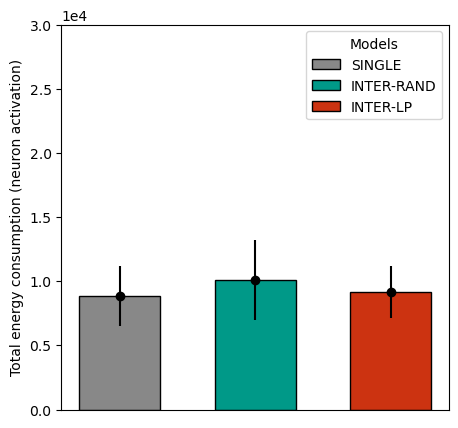

In [8]:
plt.figure(figsize=(5, 5))
model_loss_mean = np.mean(model_losses_seeds, axis=0)
model_loss_std = np.std(model_losses_seeds, axis=0)
model_energy_mean = np.mean(model_energies_seeds, axis=0)
model_energy_std = np.std(model_energies_seeds, axis=0)

for i, model in enumerate(models):
    plt.bar(model, model_energy_mean[i], width=0.6, label="{}".format(legend_label[i]),color=model_colors[model], edgecolor="black")
    plt.errorbar(model, model_energy_mean[i], yerr=model_energy_std[i], fmt="o", color="black")

plt.xticks([])
plt.ylim([0, 30000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel('Total energy consumption (neuron activation)')
plt.legend(title='Models')
plt.savefig("{}/allseeds-energy.png".format(plot_subpath), bbox_inches='tight')
plt.show()

In [9]:
# plt.figure(figsize=(5, 5))
# for i, model in enumerate(models):
#     plt.bar(model, model_loss_mean[i][-1], width=0.6, label="{}".format(legend_label[i]), color=model_colors[model], edgecolor="black")
#     plt.errorbar(model, model_loss_mean[i][-1], yerr=model_loss_std[i][-1], fmt="o", color="black")
# 
# plt.xticks([])
# plt.ylim([0, 0.5])
# # plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# plt.ylabel('Mean Absolute Prediction Error (MAE) (in meters)')
# plt.legend(title='Models')
# plt.savefig("{}/allseeds-loss.png".format(plot_subpath), bbox_inches='tight')
# plt.show()

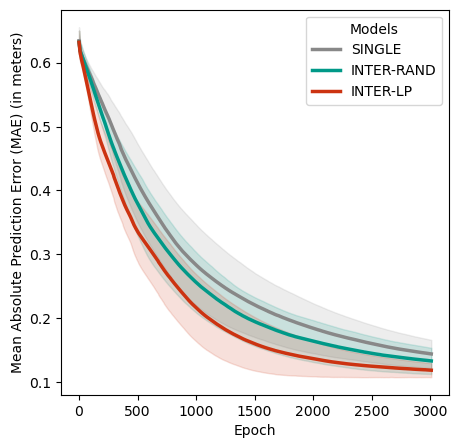

In [10]:
plt.figure(figsize=(5, 5))
for i, model in enumerate(models):
    plt.plot(range(epoch + pre_train), model_loss_mean[i], label="{}".format(legend_label[i]), color=model_colors[model], lw = 2.5)
    plt.fill_between(range(epoch + pre_train), model_loss_mean[i] - model_loss_std[i],
                     model_loss_mean[i] + model_loss_std[i], alpha=0.15, color=model_colors[model])

plt.legend(title="Models")
plt.ylabel('Mean Absolute Prediction Error (MAE) (in meters)')
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Epoch')
plt.savefig("{}/allseeds-loss.png".format(plot_subpath), bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

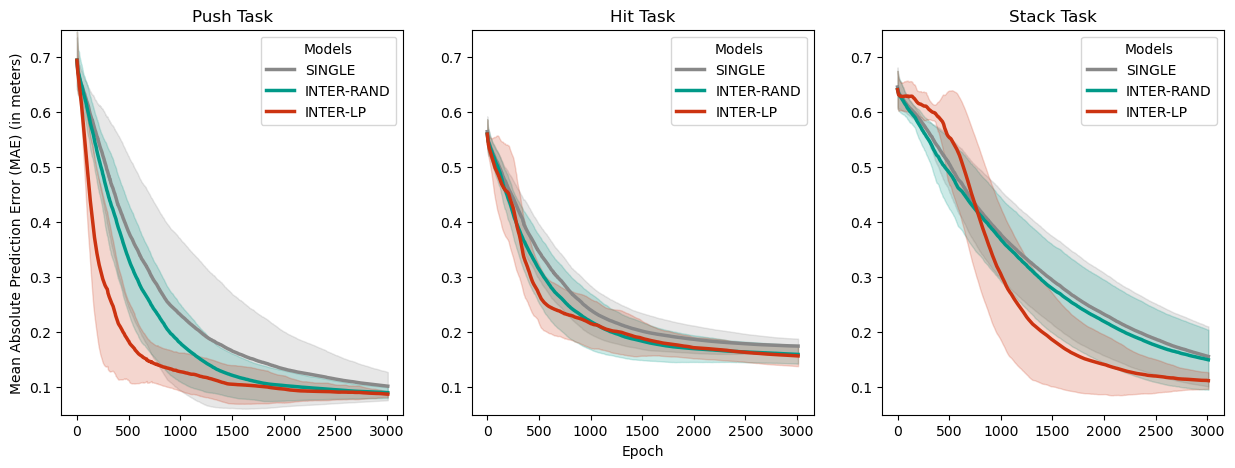

In [11]:
# Task specific plots
plt.figure(2)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
axes = [ax1, ax2, ax3]
tasks_loss_mean = np.mean(task_losses_seeds, axis=0)
tasks_loss_std = np.std(task_losses_seeds, axis=0)
for i, task in enumerate(tasks):
    for j, model in enumerate(models):
        axes[i].plot(range(epoch + pre_train), tasks_loss_mean[j][i], label="{}".format(legend_label[j]), lw=2.5, color=model_colors[model])
        axes[i].fill_between(range(epoch + pre_train), tasks_loss_mean[j][i] - tasks_loss_std[j][i],
                             tasks_loss_mean[j][i] + tasks_loss_std[j][i], alpha=0.2, color=model_colors[model])
        if i == 0:
            axes[i].set_ylabel('Mean Absolute Prediction Error (MAE) (in meters)')
        if i == 1:
            axes[i].set_xlabel('Epoch')
        axes[i].legend(title="Models")
        axes[i].set_title('{} Task'.format(task))
for ax in axes:
    ax.set_ylim([0.05, 0.75])
plt.savefig("{}/task-losses.png".format(plot_subpath), bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

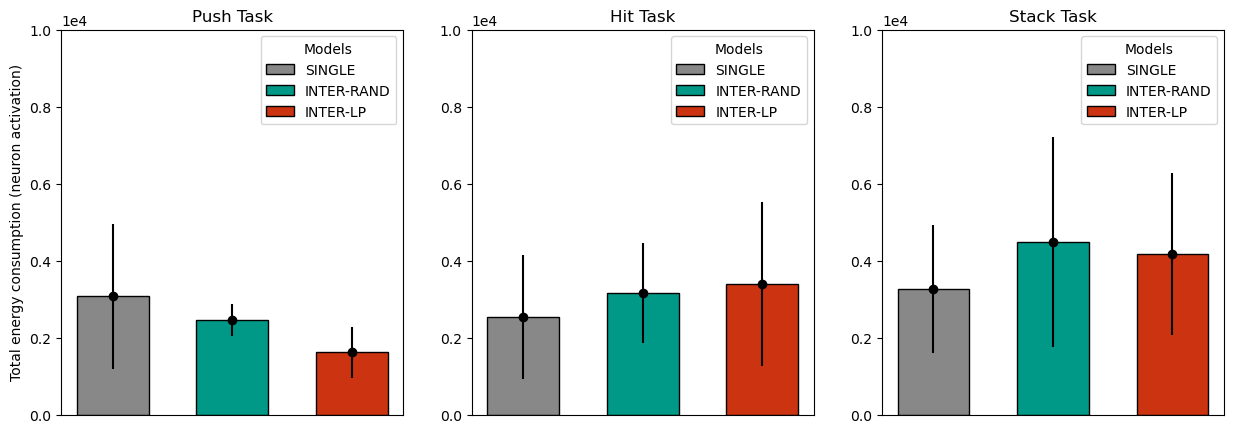

In [12]:
plt.figure(3)
f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(15, 5))
axes2 = [ax4, ax5, ax6]
tasks_energy_mean = np.mean(task_energies_seeds, axis=0)
tasks_energy_std = np.std(task_energies_seeds, axis=0)
for i, task in enumerate(tasks):
    for j, model in enumerate(models):
        axes2[i].bar(model, tasks_energy_mean[j][i], width=0.6, label="{}".format(legend_label[j]), edgecolor="black", color=model_colors[model])
        axes2[i].errorbar(model, tasks_energy_mean[j][i], yerr=tasks_energy_std[j][i], fmt="o", color="black")
        if i == 0:
            axes2[i].set_ylabel('Total energy consumption (neuron activation)')
        axes2[i].set_title('{} Task'.format(task))
        axes2[i].set_xticks([])
        axes2[i].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axes2[i].set_ylim([0, 10000])
        axes2[i].legend(title='Models')
plt.savefig("{}/task-energies.png".format(plot_subpath), bbox_inches='tight')
plt.show()

network complexity comparison

In [13]:
# 4829 - 5713
# 1813 - 1969
# 833 - 817
# around 1000. epoch
# net_size = [r"~$0.8\times 10^3$", r"~$2\times 10^3$", r"~$5.2\times 10^3$"]  # x-axis labels
# models = ['singletask', 'imtl-rand', 'imtl-lp']  # Models
# losses = {  # Loss values for each model and hidden_dim
#     'singletask': [0.2762994, 0.16573773, 0.11201764],
#     'imtl-rand': [0.25452708, 0.16324828, 0.11192292],
#     'imtl-lp': [0.20950786, 0.13942777, 0.10889132],
# }
# 
# # Bar properties
# bar_width = 0.3  # Width of each bar
# x = np.arange(len(net_size))  # Position of groups on x-axis
# 
# # Create the plot
# plt.figure(figsize=(6, 6))
# 
# for i, model in enumerate(models):
#     # Adjust position for each model
#     plt.bar(x + i * bar_width, losses[model], bar_width, color=model_colors[model], label=legend_label[i], edgecolor="black")
# 
# # Add labels, title, and legend
# plt.xlabel('Network size', fontsize=12)
# plt.ylabel('Mean Absolute Prediction Error (MAE) (in meters)', fontsize=12)
# plt.xticks(x + bar_width, net_size)  # Position x-axis ticks at the center of groups
# # plt.gca().xaxis.set_major_formatter(ScalarFormatter())
# # plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# plt.legend(title="Models")
# 
# # Show plot
# # plt.tight_layout()
# plt.savefig("paperversionplot/network_complexity.png", bbox_inches='tight')
# plt.show()
